# 1P - Model Evaluation

In [1]:
from os import path

import numpy as np
import h5py
from tqdm import tqdm
from keras.models import load_model

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from rnn_tauid.common.mpl_setup import mpl_setup
mpl_setup()

Using Theano backend.


Input files:

In [2]:
# Sample paths
sig_jet_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\sig1P_jet.h5"
bkg_jet_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\bkg1P_jet_shuffle.h5"
sig_track_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\sig1P_track.h5"
bkg_track_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\bkg1P_track_shuffle.h5"

# Model files
model_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\model.h5"
preprocessing_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\preprocessing.h5"

# Plot output prefix
plot_prefix = "C:\\Users\\chris\\Desktop\\plots"

In [3]:
# Tau-level datasets
sigf_jet = h5py.File(sig_jet_fname, "r")
bkgf_jet = h5py.File(bkg_jet_fname, "r")
sig_jet = sigf_jet["jet"]
bkg_jet = bkgf_jet["jet"]

# Track-level datasets
sigf_track = h5py.File(sig_track_fname, "r")
bkgf_track = h5py.File(bkg_track_fname, "r")
sig_track = sigf_track["track"]
bkg_track = bkgf_track["track"]

In [4]:
with h5py.File(preprocessing_fname, "r") as f:
    invars = np.char.decode(f["variables"][...]).tolist()
    offset = {v: f[v + "/offset"][...] for v in invars}
    scale = {v: f[v + "/scale"][...] for v in invars}

n_vars = len(invars)
n_tracks = len(offset[invars[0]])

In [5]:
model = load_model(model_fname)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 10)        0                                            
____________________________________________________________________________________________________
masking_1 (Masking)              (None, 10, 10)        0           input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 10, 32)        352         masking_1[0][0]                  
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            8320        timedistributed_1[0][0]          
___________________________________________________________________________________________

In [6]:
# Get the testing slice
total_frac = 0.2
test_start = int(total_frac * min(len(sig_track), len(bkg_track)))
print("[{}:] for testing".format(test_start))

[1308853:] for testing


In [7]:
sig_pred = np.zeros(len(sig_track) - test_start, dtype=np.float32)
bkg_pred = np.zeros(len(bkg_track) - test_start, dtype=np.float32)

In [8]:
buf_size = 512 * 1024**2 // (4 * n_tracks * n_vars)  # 512 MB buffer
buf = np.empty((buf_size, n_tracks, n_vars), dtype=np.float32)

In [9]:
for track, jet, pred in [(sig_track, sig_jet, sig_pred), (bkg_track, bkg_jet, bkg_pred)]:
    chunks = [(start, min(start + buf_size, len(track))) for start in range(test_start, len(track), buf_size)]
    pred_idx = 0

    for start, stop in tqdm(chunks):
        # Fill buffer (skip first because ptfrac)
        n_write = stop - start
        for i, var in enumerate(invars[1:], 1):
            # Read variable into buffer
            buf_view = buf[:n_write, :, i]
            buf_view[...] = track[start:stop, :n_tracks, var]

            # Apply preprocessing
            buf_view -= offset[var]
            buf_view /= scale[var]

            # Remove nan
            buf_view[np.isnan(buf_view)] = 0

        # Read ptfrac (TODO: make more convenient -> rnn_tauid.common.variables)
        pt_track = track[start:stop, :n_tracks, "TauTracks.pt"]
        pt_jet = jet[start:stop, "TauJets.ptJetSeed"][:, np.newaxis]

        buf_view = buf[:n_write, :, 0]
        buf_view[...] = np.clip(pt_track / pt_jet, 0.0, 1.5)
        buf_view -= offset["TauTracks.ptfrac"]
        buf_view /= scale["TauTracks.ptfrac"]
        buf_view[np.isnan(buf_view)] = 0

        # Predict
        pred[pred_idx:pred_idx + n_write] = model.predict(buf[:n_write], batch_size=512).ravel()
        pred_idx += n_write

    if not pred_idx == len(pred):
        import pdb; pdb.set_trace()
    assert pred_idx == len(pred)

del buf

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:07<00:00, 121.28s/it]


## Evaluation plots

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, binned_statistic_2d

### R21 $\tau$-ID

In [11]:
# For comparison
sig_ntuple_fname = "D:\\Dropbox\\Data\\R21-Training\\sig1P_test_deco.h5"
bkg_ntuple_fname = "D:\\Dropbox\\Data\\R21-Training\\bkg1P_test_deco.h5"

In [12]:
with h5py.File(sig_ntuple_fname, "r") as s, h5py.File(bkg_ntuple_fname, "r") as b:
    r21_y_score = np.concatenate([
        s["CollectionTree"]["vars2016_pt_gamma_1p_isofix"],
        b["CollectionTree"]["vars2016_pt_gamma_1p_isofix"]
    ])
    r21_y_true = np.concatenate([
        np.ones(len(s["CollectionTree"])), 
        np.zeros(len(b["CollectionTree"]))
    ])
    r21_weights = np.concatenate([
        s["CollectionTree"]["weight"],
        b["CollectionTree"]["weight"]
    ])
    r21_pt = np.concatenate([
        s["CollectionTree"]["TauJets.pt"],
        b["CollectionTree"]["TauJets.pt"]
    ])
    r21_mu = np.concatenate([
        s["CollectionTree"]["TauJets.mu"],
        b["CollectionTree"]["TauJets.mu"]
    ])
    r21_nVtx = np.concatenate([
        s["CollectionTree"]["TauJets.nVtxPU"],
        b["CollectionTree"]["TauJets.nVtxPU"]
    ])

In [13]:
# this should use reweighted pt

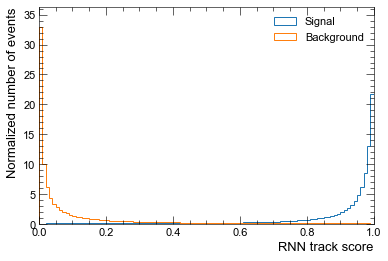

In [14]:
histopt = dict(bins=100, range=(0, 1), normed=True, histtype="step")
plt.hist(sig_pred, label="Signal", **histopt)
plt.hist(bkg_pred, label="Background", **histopt)
plt.xlabel("RNN track score", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.legend()

In [15]:
y_true = np.concatenate([np.ones_like(sig_pred), np.zeros_like(bkg_pred)])
y_score = np.concatenate([sig_pred, bkg_pred])

In [16]:
auc = roc_auc_score(y_true, y_score)
r21_auc = roc_auc_score(r21_y_true, r21_y_score)

fpr, tpr, _ = roc_curve(y_true, y_score)
r21_fpr, r21_tpr, _ = roc_curve(r21_y_true, r21_y_score)

nonzero = fpr != 0
rej = 1 / fpr[nonzero]
eff = tpr[nonzero]

r21_nonzero = r21_fpr != 0
r21_rej = 1 / r21_fpr[r21_nonzero]
r21_eff = r21_tpr[r21_nonzero]

In [17]:
roc = interp1d(eff, rej, bounds_error=False, copy=False)
r21_roc = interp1d(r21_eff, r21_rej, bounds_error=False, copy=False)

In [18]:
ratio_eff = np.linspace(0.0, 1.0, 100)
ratio = roc(ratio_eff) / r21_roc(ratio_eff)

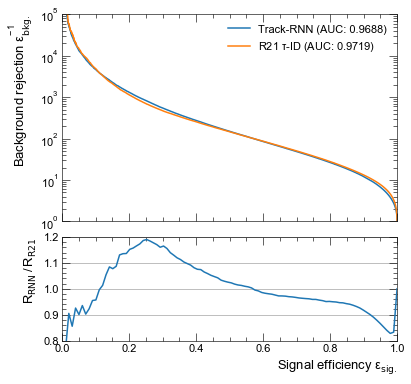

In [19]:
fig = plt.figure(figsize=(6, 6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.1)

# ROC-Curves
ax0 = plt.subplot(gs[0])
ax0.plot(eff, rej, label="Track-RNN (AUC: {:.4})".format(auc))
ax0.plot(r21_eff, r21_rej, label=r"R21 $\tau$-ID (AUC: {:.4})".format(r21_auc))
ax0.set_yscale("log")
ax0.set_xlim((0.0, 1.0))
ax0.set_ylim((1e0, 1e5))
ax0.set_ylabel(r"Background rejection $\varepsilon_\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
ax0.tick_params(labelbottom="off")
ax0.legend()

# Ratio
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(ratio_eff, ratio)
ax1.set_ylim((0.8, 1.2))
ax1.set_xlabel(r"Signal efficiency $\varepsilon_\mathrm{sig.}$", ha="right", x=1.0)
ax1.set_ylabel(r"$R_\mathrm{RNN} \, / \, R_\mathrm{R21}$", ha="right", y=1.0)
ax1.grid(axis="y")

fig.savefig(path.join(plot_prefix, "track_roc_1p.pdf"))

### $p_\mathrm{T}$ / $\mu$-flattening and working point calculation

In [83]:
wp_eff = 60

pt_bins = np.array([
    20000., 25178., 31697., 39905., 50237., 63245., 79621., 100000.,
    130000., 200000., 316978., 502377., 796214., 1261914., 2000000.
])

mu_bins = np.array([
    -0.5, 10.5, 19.5, 23.5, 27.5, 31.5, 35.5, 39.5, 49.5, 61.5
])

In [84]:
def thr_func(eff):
    def score_thr(arr):
        return np.percentile(arr, 100 - eff)
    
    return score_thr

#### R21

In [85]:
r21_is_sig = r21_y_true == 1
r21_cutmap = binned_statistic_2d(
    r21_pt[r21_is_sig],
    r21_mu[r21_is_sig],
    r21_y_score[r21_is_sig],
    statistic=thr_func(wp_eff),
    bins=[pt_bins, mu_bins]
)

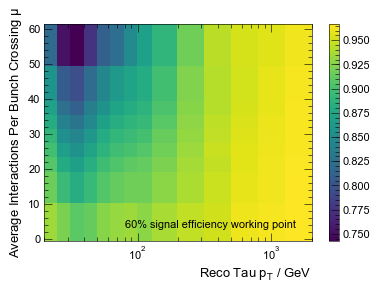

In [86]:
X, Y = np.meshgrid(r21_cutmap.x_edge, r21_cutmap.y_edge)
plt.pcolormesh(X / 1000.0, Y, r21_cutmap.statistic.T)
plt.xscale("log")
plt.xlabel(r"Reco Tau $p_\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel(r"Average Interactions Per Bunch Crossing $\mu$")
plt.annotate("{}% signal efficiency working point".format(wp_eff), xy=(0.94, 0.06), xycoords="axes fraction", horizontalalignment="right")
plt.colorbar()
plt.savefig(path.join(plot_prefix, "r21_wp_cutmap_1p.pdf"))

In [87]:
# This is weird -> investigate
mu_idx, pt_idx = np.unravel_index(
    r21_cutmap.binnumber,
    (len(r21_cutmap.y_edge) + 1, len(r21_cutmap.x_edge) + 1)
)

pt_idx = np.clip(pt_idx - 1, 0, len(pt_bins) - 2)
mu_idx = np.clip(mu_idx - 1, 0, len(mu_bins) - 2)

In [88]:
r21_thr = r21_cutmap.statistic[pt_idx, mu_idx]

In [89]:
r21_wp_mask = r21_y_score[r21_is_sig] > r21_thr

In [90]:
# Consistency check (should be approx. equal to wp_eff)
np.count_nonzero(r21_wp_mask) / len(r21_wp_mask)

0.6002562408760888

In [91]:
pt = r21_pt[r21_is_sig]

In [92]:
bins = np.percentile(pt, np.linspace(0.0, 100.0, 40))
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

r21_binned_eff = binned_statistic(
    pt,
    r21_wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

# Bayesian treatment of the error
# http://th-www.if.uj.edu.pl/~erichter/dydaktyka/Dydaktyka2012/LAB-2012/0701199v1.pdf
def binomial_error(arr):
    N = len(arr)
    K = np.count_nonzero(arr)
    eff = K / N
    return np.sqrt((K + 1) / (N + 2) * ((K + 2) / (N + 3) - (K + 1) / (N + 2)))

r21_binned_eff_err = binned_statistic(
    pt,
    r21_wp_mask,
    statistic=binomial_error,
    bins=bins
)

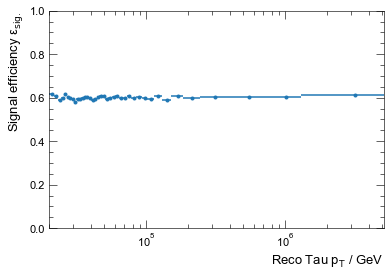

In [93]:
plt.errorbar(bin_midpoint, r21_binned_eff.statistic, xerr=bin_half_width, yerr=r21_binned_eff_err.statistic, fmt=".")
plt.ylim((0.0, 1.0))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_wp_eff_1p.pdf"))

In [94]:
nVtx_bins = np.percentile(r21_nVtx[r21_is_sig], np.linspace(0.0, 100.0, 10))
nVtx_bins -= 0.5
nVtx_bins[-1] += 1.0

bin_midpoint = (nVtx_bins[1:] + nVtx_bins[:-1]) / 2.0
bin_half_width = (nVtx_bins[1:] - nVtx_bins[:-1]) / 2.0

r21_nVtx_binned_eff = binned_statistic(
    r21_nVtx[r21_is_sig],
    r21_wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=nVtx_bins
)

r21_nVtx_binned_eff_err = binned_statistic(
    r21_nVtx[r21_is_sig],
    r21_wp_mask,
    statistic=binomial_error,
    bins=nVtx_bins
)

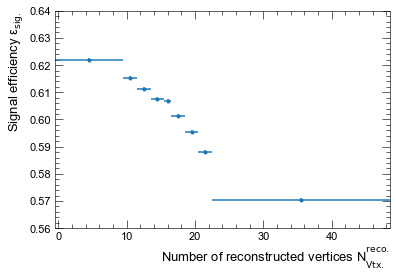

In [95]:
plt.errorbar(bin_midpoint, r21_nVtx_binned_eff.statistic, xerr=bin_half_width, yerr=r21_nVtx_binned_eff_err.statistic, fmt=".")
plt.ylim((0.56, 0.64))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_wp_eff_v_nVtx_1p.pdf"))

In [96]:
r21_rejmap = binned_statistic_2d(
    r21_pt[~r21_is_sig],
    r21_mu[~r21_is_sig],
    r21_y_score[~r21_is_sig],
    statistic="count",
    bins=[pt_bins, mu_bins]
)

In [97]:
# This is weird -> investigate
mu_idx, pt_idx = np.unravel_index(
    r21_rejmap.binnumber,
    (len(r21_rejmap.y_edge) + 1, len(r21_rejmap.x_edge) + 1)
)

pt_idx = np.clip(pt_idx - 1, 0, len(pt_bins) - 2)
mu_idx = np.clip(mu_idx - 1, 0, len(mu_bins) - 2)

In [98]:
r21_thr = r21_cutmap.statistic[pt_idx, mu_idx]

In [99]:
r21_wp_mask = r21_y_score[~r21_is_sig] > r21_thr

In [100]:
pt = r21_pt[~r21_is_sig]

In [101]:
bins = 10 ** np.linspace(np.log10(20000), np.log10(300000), 11) #np.percentile(pt, np.linspace(0.0, 100.0, 10))
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

r21_binned_eff = binned_statistic(
    pt,
    r21_wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

r21_binned_eff_err = binned_statistic(
    pt,
    r21_wp_mask,
    statistic=binomial_error,
    bins=bins
)

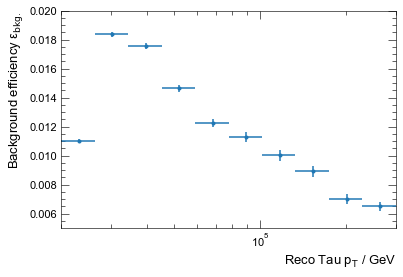

In [102]:
plt.errorbar(bin_midpoint, r21_binned_eff.statistic, xerr=bin_half_width, yerr=r21_binned_eff_err.statistic, fmt=".")
plt.ylim((0.005, 0.02))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background efficiency $\\varepsilon_\\mathrm{bkg.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_wp_bkgeff_1p.pdf"))

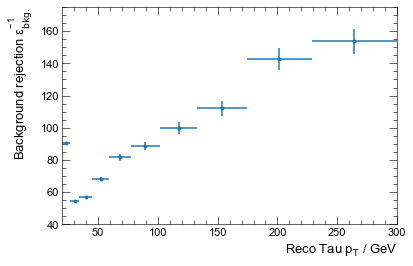

In [103]:
r21_rej = np.reciprocal(r21_binned_eff.statistic)
r21_drej = r21_binned_eff_err.statistic / r21_binned_eff.statistic**2


plt.errorbar(bin_midpoint / 1000.0, r21_rej, xerr=bin_half_width / 1000.0, yerr=r21_drej, fmt=".")
plt.xlim((20, 300))
plt.ylim((40, 175))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_rejection_1p.pdf"))

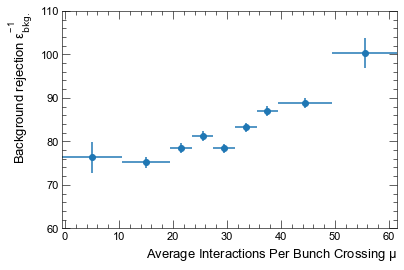

In [104]:
mu = r21_mu[~r21_is_sig]

bins = mu_bins
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

r21_mu_binned_eff = binned_statistic(
    mu,
    r21_wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

r21_mu_binned_eff_err = binned_statistic(
    mu,
    r21_wp_mask,
    statistic=binomial_error,
    bins=bins
)

r21_rej_mu = np.reciprocal(r21_mu_binned_eff.statistic)
r21_drej_mu = r21_mu_binned_eff_err.statistic / r21_mu_binned_eff.statistic**2

plt.errorbar(bin_midpoint, r21_rej_mu, xerr=bin_half_width, yerr=r21_drej_mu, fmt="o")
plt.ylim((60, 110))
plt.xlabel("Average Interactions Per Bunch Crossing $\\mu$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_rejection_mu_1p.pdf"))

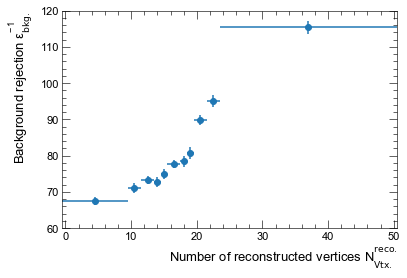

In [105]:
nVtx = r21_nVtx[~r21_is_sig]

bins = np.percentile(r21_nVtx, np.linspace(0.0, 100.0, 12))
bins -= 0.5
bins[-1] += 1.0

bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

r21_nVtx_binned_eff = binned_statistic(
    nVtx,
    r21_wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

r21_nVtx_binned_eff_err = binned_statistic(
    nVtx,
    r21_wp_mask,
    statistic=binomial_error,
    bins=bins
)

r21_rej_nVtx = np.reciprocal(r21_nVtx_binned_eff.statistic)
r21_drej_nVtx = r21_nVtx_binned_eff_err.statistic / r21_nVtx_binned_eff.statistic**2

plt.errorbar(bin_midpoint, r21_rej_nVtx, xerr=bin_half_width, yerr=r21_drej_nVtx, fmt="o")
plt.ylim((60, 120))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "r21_rejection_nVtx_1p.pdf"))

#### Track-RNN

In [106]:
cutmap = binned_statistic_2d(
    sig_jet["TauJets.pt"][test_start:], 
    sig_jet["TauJets.mu"][test_start:], 
    sig_pred, 
    statistic=thr_func(60), 
    bins=[pt_bins, mu_bins]
)

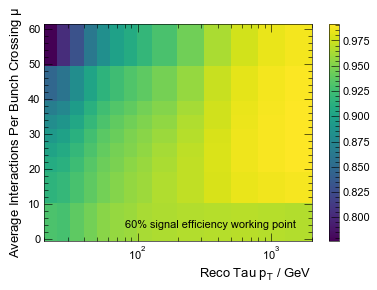

In [107]:
X, Y = np.meshgrid(cutmap.x_edge, cutmap.y_edge)
plt.pcolormesh(X / 1000.0, Y, cutmap.statistic.T)
plt.xscale("log")
plt.xlabel(r"Reco Tau $p_\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel(r"Average Interactions Per Bunch Crossing $\mu$")
plt.annotate("{}% signal efficiency working point".format(wp_eff), xy=(0.94, 0.06), xycoords="axes fraction", horizontalalignment="right")
plt.colorbar()
plt.savefig(path.join(plot_prefix, "track_wp_cutmap_1p.pdf"))

In [108]:
# This is weird -> investigate
mu_idx, pt_idx = np.unravel_index(
    cutmap.binnumber,
    (len(cutmap.y_edge) + 1, len(cutmap.x_edge) + 1)
)

pt_idx = np.clip(pt_idx - 1, 0, len(pt_bins) - 2)
mu_idx = np.clip(mu_idx - 1, 0, len(mu_bins) - 2)

In [109]:
thr = cutmap.statistic[pt_idx, mu_idx]
wp_mask = sig_pred > thr

In [110]:
pt = sig_jet["TauJets.pt"][test_start:]

In [111]:
bins = np.percentile(pt, np.linspace(0.0, 100.0, 40))
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

binned_eff = binned_statistic(
    pt,
    wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

binned_eff_err = binned_statistic(
    pt,
    wp_mask,
    statistic=binomial_error,
    bins=bins
)

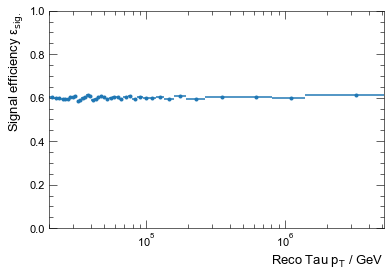

In [112]:
plt.errorbar(bin_midpoint, binned_eff.statistic, xerr=bin_half_width, yerr=binned_eff_err.statistic, fmt=".")
plt.ylim((0.0, 1.0))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_wp_eff_1p.pdf"))

In [113]:
nVtxPU = sig_jet["TauJets.nVtxPU"][test_start:]

bin_midpoint = (nVtx_bins[1:] + nVtx_bins[:-1]) / 2.0
bin_half_width = (nVtx_bins[1:] - nVtx_bins[:-1]) / 2.0

nVtx_binned_eff = binned_statistic(
    nVtxPU,
    wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=nVtx_bins
)

nVtx_binned_eff_err = binned_statistic(
    nVtxPU,
    wp_mask,
    statistic=binomial_error,
    bins=nVtx_bins
)

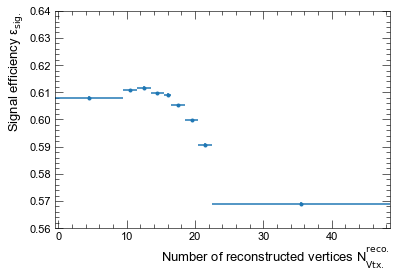

In [114]:
plt.errorbar(bin_midpoint, nVtx_binned_eff.statistic, xerr=bin_half_width, yerr=nVtx_binned_eff_err.statistic, fmt=".")
#plt.errorbar(bin_midpoint, r21_nVtx_binned_eff.statistic, xerr=bin_half_width, yerr=r21_nVtx_binned_eff_err.statistic, fmt=".")
plt.ylim((0.56, 0.64))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_wp_eff_nVtx_1p.pdf"))

In [115]:
rejmap = binned_statistic_2d(
    bkg_jet["TauJets.pt"][test_start:],
    bkg_jet["TauJets.mu"][test_start:],
    bkg_pred,
    statistic="count",
    bins=[pt_bins, mu_bins]
)

In [116]:
# This is weird -> investigate
mu_idx, pt_idx = np.unravel_index(
    rejmap.binnumber,
    (len(rejmap.y_edge) + 1, len(rejmap.x_edge) + 1)
)

pt_idx = np.clip(pt_idx - 1, 0, len(pt_bins) - 2)
mu_idx = np.clip(mu_idx - 1, 0, len(mu_bins) - 2)

In [117]:
thr = cutmap.statistic[pt_idx, mu_idx]

In [118]:
wp_mask = bkg_pred > thr

In [119]:
pt = bkg_jet["TauJets.pt"][test_start:]

In [120]:
bins = 10 ** np.linspace(np.log10(20000), np.log10(300000), 11) #np.percentile(pt, np.linspace(0.0, 100.0, 10))
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

binned_eff = binned_statistic(
    pt,
    wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

binned_eff_err = binned_statistic(
    pt,
    wp_mask,
    statistic=binomial_error,
    bins=bins
)

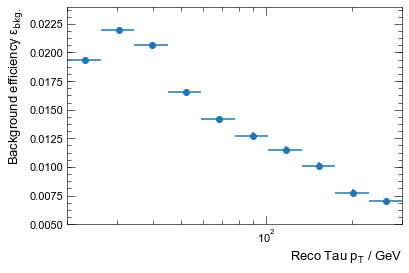

In [121]:
plt.errorbar(bin_midpoint / 1000.0, binned_eff.statistic, xerr=bin_half_width / 1000.0, yerr=binned_eff_err.statistic, fmt="o")
plt.ylim((0.005, 0.024))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background efficiency $\\varepsilon_\\mathrm{bkg.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_wp_bkgeff_1p.pdf"))

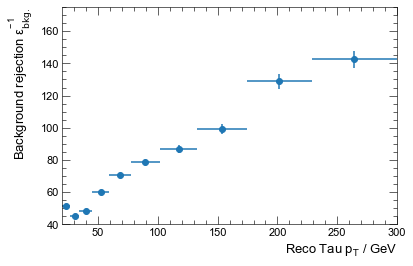

In [122]:
rej = np.reciprocal(binned_eff.statistic)
drej = binned_eff_err.statistic / binned_eff.statistic**2

plt.errorbar(bin_midpoint / 1000.0, rej, xerr=bin_half_width / 1000.0, yerr=drej, fmt="o")
plt.xlim((20, 300))
plt.ylim((40, 175))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_rejection_1p.pdf"))

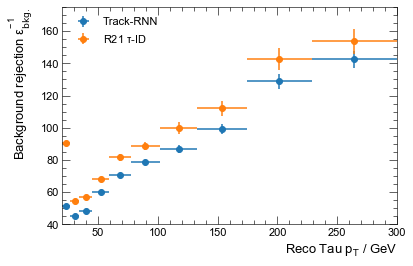

In [123]:
plt.errorbar(bin_midpoint / 1000.0, rej, xerr=bin_half_width / 1000.0, yerr=drej, fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_rej, xerr=bin_half_width / 1000.0, yerr=r21_drej, fmt="o", label="R21 $\\tau$-ID")
plt.xlim((20, 300))
plt.ylim((40, 175))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()
plt.savefig(path.join(plot_prefix, "track_r21_rejection_1p.pdf"))

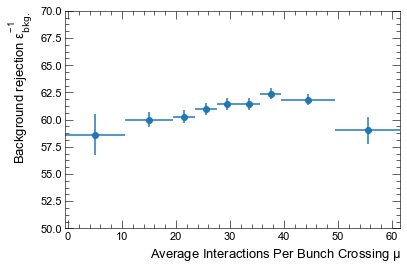

In [124]:
mu = bkg_jet["TauJets.mu"][test_start:]

bins = mu_bins
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

mu_binned_eff = binned_statistic(
    mu,
    wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

mu_binned_eff_err = binned_statistic(
    mu,
    wp_mask,
    statistic=binomial_error,
    bins=bins
)

rej_mu = np.reciprocal(mu_binned_eff.statistic)
drej_mu = mu_binned_eff_err.statistic / mu_binned_eff.statistic**2

plt.errorbar(bin_midpoint, rej_mu, xerr=bin_half_width, yerr=drej_mu, fmt="o")
#plt.xlim((20, 300))
plt.ylim((50, 70))
plt.xlabel("Average Interactions Per Bunch Crossing $\\mu$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_rejection_mu_1p.pdf"))

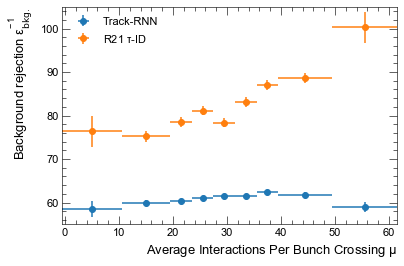

In [125]:
plt.errorbar(bin_midpoint, rej_mu, xerr=bin_half_width, yerr=drej_mu, fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint, r21_rej_mu, xerr=bin_half_width, yerr=r21_drej_mu, fmt="o", label="R21 $\\tau$-ID")
plt.ylim((55, 105))
plt.xlabel("Average Interactions Per Bunch Crossing $\\mu$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()
plt.savefig(path.join(plot_prefix, "track_rejection_mu_1p.pdf"))

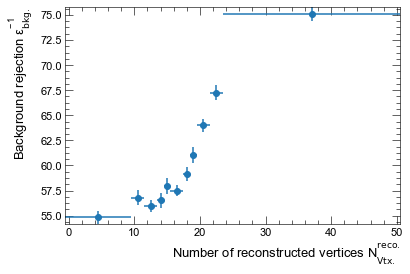

In [126]:
nVtx = bkg_jet["TauJets.nVtxPU"][test_start:]

bins = np.percentile(r21_nVtx, np.linspace(0.0, 100.0, 12))
bins -= 0.5
bins[-1] += 1.0

bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

nVtx_binned_eff = binned_statistic(
    nVtx,
    wp_mask,
    statistic=lambda arr: np.count_nonzero(arr) / len(arr),
    bins=bins
)

nVtx_binned_eff_err = binned_statistic(
    nVtx,
    wp_mask,
    statistic=binomial_error,
    bins=bins
)

rej_nVtx = np.reciprocal(nVtx_binned_eff.statistic)
drej_nVtx = nVtx_binned_eff_err.statistic / nVtx_binned_eff.statistic**2

plt.errorbar(bin_midpoint, rej_nVtx, xerr=bin_half_width, yerr=drej_nVtx, fmt="o")
#plt.ylim((60, 120))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "track_rejection_nVtx_1p.pdf"))

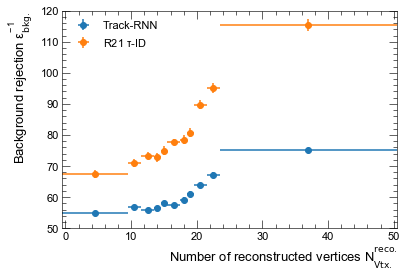

In [127]:
plt.errorbar(bin_midpoint, rej_nVtx, xerr=bin_half_width, yerr=drej_nVtx, fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint, r21_rej_nVtx, xerr=bin_half_width, yerr=r21_drej_nVtx, fmt="o", label="R21 $\\tau$-ID")
plt.ylim((50, 120))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()
plt.savefig(path.join(plot_prefix, "track_r21_rejection_nVtx_1p.pdf"))

In [128]:
sigf_jet.close()
bkgf_jet.close()
sigf_track.close()
bkgf_track.close()